# Abstract

Treat mixture GARCH as RNN.

In [1]:
import jax; jax.config.update("jax_enable_x64", True)
import jax.numpy as np, jax.random as rnd
import jax.flatten_util
import equinox as eqx
from scipy.optimize import minimize

In [2]:
from tqdm.notebook import tqdm
import polars as pl, pandas as pd
import matplotlib, matplotlib.pyplot as plt
plt.style.use('grayscale')
matplotlib.rcParams['figure.facecolor'] = 'white'

In [3]:
def npdf(x, mu, var):
    return np.exp(-0.5 * (x - mu)**2 / var) / np.sqrt(2 * np.pi * var)

def loss_normal(var_pred, series):
    logliks = -np.log(var_pred) - series**2 / var_pred
    return -logliks.mean()

def loss_mix(vars_pred, series, weights):
    # vars_pred: (T, K)
    # series: (T, 1)
    # weights: (K,)
    pdf_exponents = (
        - 0.5 * np.log(2 * np.pi) - 0.5 * np.log(vars_pred) - 0.5 * series**2 / vars_pred
    ) # (T, K)
    logpdfs = jax.scipy.special.logsumexp(pdf_exponents, axis=1, b=weights)
    return -logpdfs.mean()

## Regular GARCH model

Conditional distribution of returns $r_t$ is Gaussian with variance following this dynamics:

$$
\sigma_{t+1}^2 = \omega + \alpha r_t^2 + \beta \sigma_t^2
$$

I want the code to be similar to an RNN, so I rename:

- $\omega\to$ `bias`
- $\alpha\to$ `Wx` (weight for the input series)
- $\beta\to$ `Wh` (weight for the hidden state $\sigma_t^2$)

GARCH imposes constraints on parameters $(\omega,\alpha,\beta)$ to keep $\sigma_t^2$ positive. I draw from RNN ideas and use `ReLU` activation for the hidden state:

$$
\sigma_{t+1}^2 = \operatorname{ReLU}\left(
    b + W_x r_t^2 + w_h \sigma_t^2
\right)
$$

This means that in theory, we can lift all constraints and let $b\in\mathbb R, W_x \in \mathbb R, w_h \in (-1, 1)$. The simple bounds constraint on $w_h$ is needed to ensure that $\sigma_t^2$ doesn't blow up.

In [4]:
class GARCHCell(eqx.Module):
    bias: np.ndarray
    Wx: np.ndarray
    Wh: np.ndarray
    def __init__(self, *, key: rnd.PRNGKey):
        k1, k2 = rnd.split(key)
        self.bias = rnd.uniform(k1, (1, ))
        _, a, b = rnd.dirichlet(k2, np.ones(3))
        self.Wx, self.Wh = np.array([a]), np.array([b])

    def __call__(self, var_prev: np.ndarray, obs: np.ndarray):
        var = self.bias + self.Wx * obs + self.Wh * var_prev
        return var, var

class GARCHCellReLU(GARCHCell):
    def __init__(self, *, key: rnd.PRNGKey):
        self.bias, self.Wx, self.Wh = rnd.uniform(key, (3, 1))

    def __call__(self, var_prev: np.ndarray, obs: np.ndarray):
        var = jax.nn.relu(self.bias + self.Wx * obs + self.Wh * var_prev) + 1e-6
        return var, var

class GARCH(eqx.Module):
    cell: GARCHCell | GARCHCellReLU
    var0: np.ndarray = eqx.field(static=True)
    
    def __init__(self, var0: float, cell_cls=GARCHCell, *, key: rnd.PRNGKey):
        self.cell = cell_cls(key=key)
        self.var0 = np.array([var0])

    def __call__(self, series: np.ndarray):
        # `series` indexed by t=[0,1,2, ..., T]
        _, hist = jax.lax.scan(self.cell.__call__, self.var0, series)
        return hist # values for t=[1, 2, ..., T, T+1]

    def predict(self, series: np.ndarray):
        return self(series)[-1]
        
    def fit(self, series: np.ndarray, tol=1e-6):
        assert series.ndim == 1
        params0, rebuild = jax.flatten_util.ravel_pytree(self)
        @jax.jit
        def loss(params: np.ndarray):
            model = rebuild(params)
            vars_pred = model(series**2).flatten()
            return loss_normal(vars_pred[:-1], series[1:])
        @jax.jit
        def constr(params: np.ndarray):
            # a + b < 1 => 1 - (a + b) > 0
            model: GARCH = rebuild(params)
            return 1 - (model.cell.Wh[0] + model.cell.Wx[0])

        if isinstance(self.cell, GARCHCell):
            bounds = [(0, None), (0, None), (0, None)]
            constraints = [{'type': 'ineq', 'fun': constr}]
        else:
            bounds = [(None, None), (None, None), (-1, 1)]
            constraints = None
        
        sol = minimize(
            loss, params0, method='SLSQP',
            bounds=bounds, constraints=constraints, tol=tol
        )
        N = series.shape[0]
        lnL = N * -loss(sol.x)
        aic = -2 * lnL + 2 * len(sol.x)
        bic = -2 * lnL + np.log(len(series)) * len(sol.x)
        return rebuild(sol.x), sol, {'aic': aic.item(), 'bic': bic.item()}

## Mixture GARCH-RNN

Assume conditional distribution of $r_t$ is a mixture of Gaussians (as opposed to a single Gaussian in GARCH):

$$
p(r_t|r_{t-1}, \dots) = \sum_{k=1}^K p_k \mathcal{N}(r_t; \mu_k, \sigma_{k,t}^2)
$$

Similar to GARCH, assume each variance $\sigma_{k,t}^2$ has GARCH-like dynamics. Write this in vector form:

$$
\vec \sigma_{t+1}^2 = \mathrm{ReLU}\left(
    \vec b + \mathbf W_x r_t^2 + \vec w_h \odot \vec \sigma_{t}^2
\right)
$$

Usually, $\mathrm{ReLU}$ is _not_ used, so the dynamics are linear, but again need constraints for coefficients to enforce $\sigma_{k,t}^2>0\;\forall k,t$.

Here I introduce the $\mathrm{ReLU}$ to remove these constraints because output of $\mathrm{ReLU}$ is non-negative.

This is similar to projected gradient descent, where $\mathrm{ReLU}$ is the projection onto non-negative orthant, $\mathbb R_+$.

In [5]:
class MixGARCHCellReLU(eqx.Module):
    bias: np.ndarray
    Wx: np.ndarray
    Wh: np.ndarray
    def __init__(self, ncomp: int, n_in: int=1, *, key: rnd.PRNGKey):
        k1, k2, k3 = rnd.split(key, 3)
        init_bias = jax.nn.initializers.uniform()
        init_Wx = jax.nn.initializers.uniform()
        init_Wh = jax.nn.initializers.uniform(0.9)
        
        self.bias = init_bias(k1, (ncomp, ))
        self.Wx = init_Wx(k2, (ncomp, n_in))
        self.Wh = init_Wh(k3, (ncomp, ))

    def __call__(self, vars_prev: np.ndarray, obs: np.ndarray):
        vars = jax.nn.relu(self.bias + self.Wx @ obs + self.Wh * vars_prev) + 1e-6
        return vars, vars

class MixGARCH(eqx.Module):
    cell: MixGARCHCellReLU
    weights: np.ndarray
    vars0: np.ndarray = eqx.field(static=True)
    
    def __init__(self, vars0: np.ndarray, n_in: int=1, cell_cls=MixGARCHCellReLU, *, key: rnd.PRNGKey):
        self.vars0 = np.array(vars0)
        K = len(self.vars0)
        self.cell = cell_cls(K, n_in, key=key)
        self.weights = np.ones(K) / K

    def __call__(self, series: np.ndarray):
        """
        `series` must be (T, 1)
        Indexed by t=[0,1,2, ..., T]
        """
        _, hist = jax.lax.scan(self.cell.__call__, self.vars0, series)
        return hist # values for t=[1, 2, ..., T, T+1]

    def condvar(self, series):
        variances = self(series)
        return variances @ self.weights

    def predict(self, series: np.ndarray):
        return self.condvar(series).flatten()[-1]
        
    def fit(self, series: np.ndarray, tol=1e-6):
        """
        `series[:, 0]` must contain most recent lags of log-returns!
        """
        assert series.ndim == 2
        params0, rebuild = jax.flatten_util.ravel_pytree(self)
        @jax.jit
        def loss(params: np.ndarray):
            model = rebuild(params)
            vars_pred = model(series**2) # shape (T, K)
            return loss_mix(vars_pred[:-1, :], series[1:, :1], model.weights)
        @jax.jit
        def constr(params: np.ndarray):
            # a + b < 1 => 1 - (a + b) > 0
            model: MixGARCH = rebuild(params)
            return model.weights.sum() - 1 # == 0

        K = len(self.weights)
        sol = minimize(
            loss, params0, method='SLSQP',
            bounds=[(None, None)] * K + [(None, None)] * (K * series.shape[1]) + [(-1, 1)] * K + [(0, None)] * K, # bias, Wx, Wh, weights
            constraints=[{'type': 'eq', 'fun': constr}], tol=tol
        )

        N = series.shape[0]
        lnL = N * -loss(sol.x)
        aic = -2 * lnL + 2 * len(sol.x)
        bic = -2 * lnL + np.log(len(series)) * len(sol.x)
        return rebuild(sol.x), sol, {'aic': aic.item(), 'bic': bic.item()}

## Fit using real data

In [6]:
df = pl.read_parquet("../data/returns_rv_1d.parquet").filter(
    pl.col("Ticker") == "AFLT"
).select(pl.col("Ret_Close")*100)["Ret_Close"]
df.head()

Ret_Close
f64
-1.376254
3.604657
-2.11764
0.698661
0.766567
1.300596
-0.215595
0.930905
-1.870558


2.165865471763416


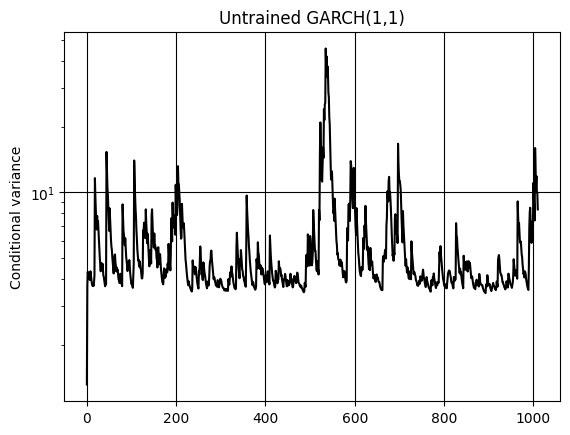

In [7]:
series = np.array(df)
model = GARCH(0.3, key=rnd.PRNGKey(7))
var = model(series**2)

print(loss_normal(var.flatten()[:-1], series[1:]))
plt.plot(var.flatten());
plt.ylabel('Conditional variance');
plt.title("Untrained GARCH(1,1)"); plt.yscale('log'); plt.grid();

In [8]:
def logpdfs_basic(vars_pred, series, weights):
    return np.log(npdf(series_, 0, vars_pred) @ weights)

def logpdfs_logsumexp(vars_pred, series, weights):
    pdf_exponents = - 0.5 * np.log(2 * np.pi) - 0.5 * np.log(vars_pred) - 0.5 * series**2 / vars_pred # (T, K)
    print(pdf_exponents.shape)
    return jax.scipy.special.logsumexp(pdf_exponents, axis=1, b=weights)
    
series_ = series.reshape((-1, 1))
model = MixGARCH([0.3, 0.5], key=rnd.PRNGKey(6))
log_1 = logpdfs_basic(model(series_**2), series_, model.weights)
log_2 = logpdfs_logsumexp(model(series_**2), series_, model.weights)

abs(log_1 - log_2).max().item()

(1011, 2)


1.4210854715202004e-14

### Fit for AFLT and compare AIC and BIC

In [9]:
key = rnd.PRNGKey(14)
garch_opt1, garch_sol1, crit1 = GARCH(0.3, GARCHCell, key=key).fit(series)
garch_opt2, garch_sol2, crit2 = GARCH(0.3, GARCHCellReLU, key=key).fit(series)
print(crit1, crit2)
print(garch_sol1)
print(garch_sol2)

{'aic': 4020.189944060987, 'bic': 4034.946029718048} {'aic': 4020.1898137284993, 'bic': 4034.9458993855606}
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.9852571434525157
       x: [ 4.076e-01  2.300e-01  6.609e-01]
     nit: 10
     jac: [-1.060e-03 -2.430e-03 -2.858e-03]
    nfev: 42
    njev: 10
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.9852570789953012
       x: [ 4.071e-01  2.299e-01  6.612e-01]
     nit: 11
     jac: [-5.887e-04 -1.825e-03 -1.574e-03]
    nfev: 49
    njev: 11


In [10]:
mix_opt, mix_sol, mix_crit = MixGARCH(np.full(3, 0.1), key=rnd.PRNGKey(4)).fit(
    series.reshape((-1, 1))
)
print(mix_crit)
mix_sol

{'aic': 3704.0000448207284, 'bic': 3763.024387448974}


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.8199802397728626
       x: [ 2.709e+00 -1.029e-01  8.479e-02  1.042e+00  6.600e-01
            8.135e-02  5.311e-01  5.455e-01  7.964e-01  1.344e-01
            7.404e-02  7.915e-01]
     nit: 53
     jac: [-4.087e-04 -9.210e-03 -9.813e-03  6.977e-04 -1.704e-03
           -5.209e-03 -1.227e-03 -3.011e-03 -5.259e-03 -1.008e+00
           -1.004e+00 -9.982e-01]
    nfev: 732
    njev: 53

In [11]:
mix_opt.weights

Array([0.13444336, 0.07404105, 0.79151559], dtype=float64)

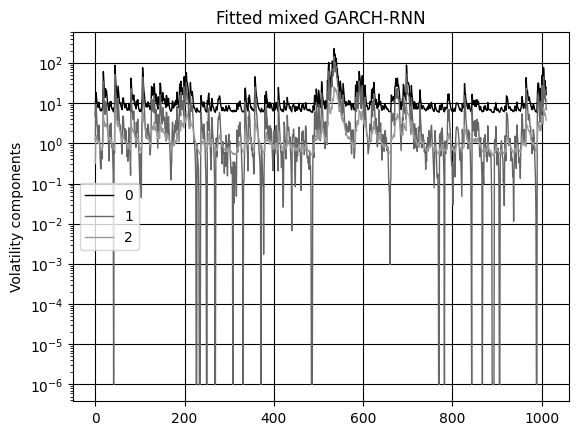

In [12]:
plt.plot(mix_opt( series.reshape((-1, 1))**2 ), linewidth=1, label=range(len(mix_opt.weights)))
plt.ylabel("Volatility components")
plt.title("Fitted mixed GARCH-RNN")
plt.grid(); plt.legend(); plt.yscale('log');

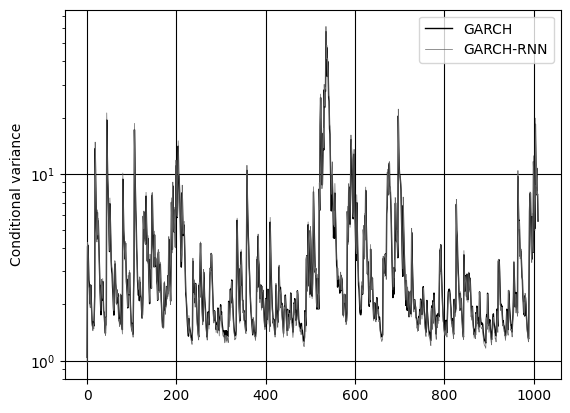

In [13]:
plt.plot(garch_opt1(series**2).flatten(), linewidth=1, label="GARCH");
plt.plot(mix_opt.condvar( series.reshape((-1, 1))**2 ), linewidth=0.5, label="GARCH-RNN")
plt.ylabel("Conditional variance")
plt.yscale('log'); plt.legend()
plt.grid();

## Investigate dependence on initial parameters

In [14]:
def fit_many(series, vars0: np.ndarray, seeds: np.ndarray, colors=["r", "g", "b"], linewidth=0.1, verbose=0):
    series = np.asarray(series)
    vars0 = np.asarray(vars0)
    assert series.ndim == 1
    
    series = series.reshape((-1, 1))
    series_sq = series**2

    weights_sorted = []
    variances_sorted = [list() for _ in vars0]
    condvars = []
    for seed in tqdm(seeds):
        model, sol, _ = MixGARCH(
            vars0, key=rnd.PRNGKey(seed)
        ).fit(series)
        
        idxs = model.weights.argsort()
        weights = model.weights[idxs]
        vars = model( series_sq )[:, idxs] # shape (T, K)

        if verbose: print(seed, weights)
        weights_sorted.append(weights)

        for k, _ in enumerate(idxs):
            var_component = vars[:, k]
            if (var_component < 1e-4).any():
                continue
            variances_sorted[k].append(var_component)
        condvars.append(model.condvar(series_sq))

    variances_sorted = [np.vstack(var) for var in variances_sorted]
    return np.vstack(weights_sorted), variances_sorted, np.vstack(condvars)

In [15]:
weights, variances, condvars = fit_many(series, np.full(3, 0.1), range(150), linewidth=0.02)

  0%|          | 0/150 [00:00<?, ?it/s]

In [16]:
weights_mean = weights.mean(0)
weights_mean

Array([0.0964619 , 0.19486457, 0.70867354], dtype=float64)

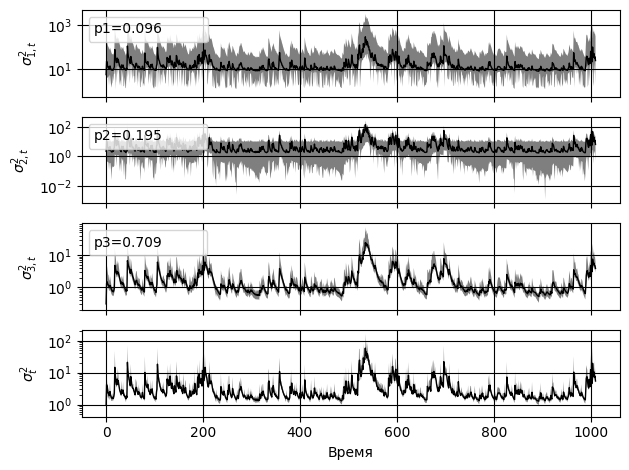

In [17]:
var0, var1, var2 = variances[0], variances[1], variances[2]
x = np.arange(var0.shape[1])
EMPTY_HANDLE = matplotlib.patches.Rectangle(
    (0,0), 1, 1, fill=False, edgecolor='none', visible=False
) # https://stackoverflow.com/a/16942405

fig, axs = plt.subplots(4, sharex=True)
axs[-1].set_xlabel('Время')

for ax in axs:
    ax.set_yscale('log')
    ax.grid(True)

for i, (ax, var, weight) in enumerate(zip(axs, variances, weights_mean), 1):
    ax.set_ylabel(fr'$\sigma_{{{i},t}}^2$')
    ax.fill_between(x, var.max(0), var.min(0), alpha=0.5)
    ax.plot(x, var.mean(0), linewidth=1)

    ax.legend([EMPTY_HANDLE], [f'p{i}={weight:.3f}'], loc='upper left', markerfirst=False)

axs[-1].set_ylabel(r'$\sigma_{t}^2$')
axs[-1].fill_between(x, condvars.max(0), condvars.min(0), alpha=0.5, linewidth=0)
axs[-1].plot(x, condvars.mean(0), linewidth=1)
fig.tight_layout(); fig;

1. Component with highest weight (blue) is very stable, doesn't seem to depend on initial parameters at all.
2. Component with lower weight (green) changes a bit but is stable overall.
3. Component with lowest weight (red) may be a little more erratic (see faint red glow above solid red graph), but is basically OK.

Overall mixture variance looks very stable.

## Compute AIC & BIC for many tickers

In [26]:
def fit_over_tickers(df: pl.DataFrame, vars0: list, seeds: list[int]) -> pl.DataFrame:
    vars0 = np.asarray(vars0)
    tickers = sorted(df["Ticker"].unique())
    results = []
    
    for i, ticker in enumerate(tickers):
        print(ticker, end=' ')
        series = df.filter(pl.col("Ticker") == ticker).select(
            pl.col("Ret_Close") * 100
        )["Ret_Close"]
        series = np.array(series).reshape((-1, 1))
        series_sq = series**2

        aics_GARCH, bics_GARCH = [], []
        aics_mix, bics_mix = [], []
        for seed in seeds:
            key = rnd.PRNGKey(seed)
            _, _, crit_garch = GARCH(vars0[0], key=key).fit(series.flatten())
            _, _, crit_mix = MixGARCH(vars0, key=key).fit(series)

            results.append([ticker, seed, "GARCH", crit_garch['aic'], crit_garch['bic']])
            results.append([ticker, seed, "MixGARCH", crit_mix['aic'], crit_mix['bic']])
        
    return pl.DataFrame(results, {'Ticker': str, 'Seed': int, 'Model': str, 'AIC': float, 'BIC': float})
        
df_crit = fit_over_tickers(
    pl.read_parquet("../data/returns_rv_1d.parquet"), np.full(3, 0.3), range(10)
)
df_crit.head()

AFLT ALRS BANE CBOM FESH GAZP INGR KAZT KMAZ LKOH LVHK MGTS MTSS MVID ROSN SBER UTAR VTBR ZILL 

Ticker,Seed,Model,AIC,BIC
str,i64,str,f64,f64
"""AFLT""",0,"""GARCH""",4020.190277,4034.946362
"""AFLT""",0,"""MixGARCH""",3702.396604,3761.420947
"""AFLT""",1,"""GARCH""",4020.189817,4034.945903
"""AFLT""",1,"""MixGARCH""",3702.71705,3761.741392
"""AFLT""",2,"""GARCH""",4020.189875,4034.945961


In [27]:
df_crit_pivoted = df_crit.group_by("Ticker", "Model").agg(
    pl.col("AIC").mean(), pl.col("BIC").mean()
).sort("Ticker").pivot(
    values=["AIC", "BIC"], index="Ticker", columns="Model", sort_columns=True
).with_columns(
    rnn_AIC=pl.when(
        pl.col("AIC_Model_MixGARCH") < pl.col('AIC_Model_GARCH')
    ).then(pl.lit('+')).otherwise(pl.lit('-')),
    rnn_BIC=pl.when(
        pl.col("BIC_Model_MixGARCH") < pl.col('BIC_Model_GARCH')
    ).then(pl.lit('+')).otherwise(pl.lit('-')),
).select(
    'Ticker',
    'AIC_Model_GARCH', 'AIC_Model_MixGARCH', 'rnn_AIC',
    'BIC_Model_GARCH', 'BIC_Model_MixGARCH', 'rnn_BIC',
).rename({
    'Ticker': 'Тикер',
    'AIC_Model_GARCH': 'AIC GARCH', 'AIC_Model_MixGARCH': 'AIC GARCH-RNN',
    'BIC_Model_GARCH': 'BIC GARCH', 'BIC_Model_MixGARCH': 'BIC GARCH-RNN',
    'rnn_AIC': 'GARCH-RNN лучше? (AIC)', 'rnn_BIC': 'GARCH-RNN лучше? (BIC)',
})
print(df_crit_pivoted.to_pandas().to_markdown(index=False, floatfmt="8.1f"))

| Тикер   |   AIC GARCH |   AIC GARCH-RNN | GARCH-RNN лучше? (AIC)   |   BIC GARCH |   BIC GARCH-RNN | GARCH-RNN лучше? (BIC)   |
|:--------|------------:|----------------:|:-------------------------|------------:|----------------:|:-------------------------|
| AFLT    |      4020.2 |          3704.9 | +                        |      4034.9 |          3763.9 | +                        |
| ALRS    |      4297.7 |          3979.8 | +                        |      4312.5 |          4038.8 | +                        |
| BANE    |      3009.5 |          3076.8 | -                        |      3024.3 |          3135.9 | -                        |
| CBOM    |      1741.9 |          2593.9 | -                        |      1756.6 |          2652.9 | -                        |
| FESH    |      5918.2 |          4335.5 | +                        |      5933.0 |          4394.6 | +                        |
| GAZP    |      4285.3 |          3838.5 | +                        |      4300.1 |      

In [20]:
df_crit.select(
    (pl.col("AIC").filter(pl.col("Model") == "MixGARCH") < pl.col("AIC").filter(pl.col("Model") == "GARCH")).mean(),
    (pl.col("BIC").filter(pl.col("Model") == "MixGARCH") < pl.col("BIC").filter(pl.col("Model") == "GARCH")).mean(),
)

AIC,BIC
f64,f64
0.842105,0.842105


Mixture GARCH-RNN had higher AIC and BIC about 85% of the time.

## Fit GARCH(2, 1)-RNN

In [21]:
series_2 = np.hstack((series_[1:, :], series_[:-1, :]))
series_2.shape

(1010, 2)

In [22]:
mix_2, mix_sol_2, mix_crit_2 = MixGARCH(
    np.full(3, 0.1), series_2.shape[1], key=rnd.PRNGKey(8)
).fit(series_2)
print(mix_crit_2)
mix_sol_2

{'aic': 3690.92690357761, 'bic': 3764.6924877251395}


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.8123400512760446
       x: [ 4.186e+00 -1.220e-02 ...  3.452e-01  5.350e-01]
     nit: 88
     jac: [-8.598e-05 -6.233e-03 ... -9.999e-01 -1.000e+00]
    nfev: 1478
    njev: 88

Model can reflect _negative_ dependence of variance on some features. Weights can be negative.

In [23]:
mix_2.cell.Wx

Array([[-0.14751442,  1.40798429],
       [ 0.52037733, -0.39238304],
       [-0.00706182,  0.08522788]], dtype=float64)

In [24]:
mix_2.cell.Wh

Array([0.36418402, 0.83479929, 0.79000625], dtype=float64)

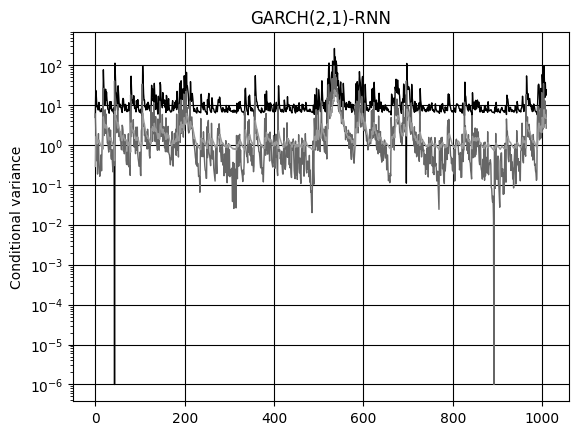

In [25]:
plt.plot(mix_2(series_2**2), linewidth=1)
plt.ylabel("Conditional variance"); plt.title("GARCH(2,1)-RNN")
plt.yscale('log'); plt.grid();